# Analyze Upsampling by WaveGlow

In [34]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd

%matplotlib inline

In [35]:
def get_lsd(true_specgram, synth_specgram):
    """Inputs are Power spectrum (db), output is the log spectral distance
    """
    squared_error = (true_specgram - synth_specgram)**2
    return np.mean(np.sqrt(np.mean(squared_error, axis=0)))

def get_db_specgram(y):
    S = np.abs(librosa.stft(y))**2
    S_dB = librosa.power_to_db(S, ref=np.max)
    return S_dB
    
def plot_specgram(spec, title, sr, plt_num):
    ax = plt.subplot(plt_num)
    librosa.display.specshow(spec, x_axis='time',y_axis='linear', fmax=sr)
    plt.title(title)
    return ax

def get_snr(orig, synth):
    return 10*np.log10(np.sum((orig)**2)/np.sum((synth-orig)**2))
    

In [59]:
# Load original audio, downsampled and reconstruction
orig_path = '/home/homer/Documents/wavenet/LJSpeech-1.1/wavs/LJ001-0001.wav'
synth_path = 'test/synth/LJ001-0001.wav'

def get_lsd_snr(orig_path, synth_path):
    orig, sr_orig = librosa.load(orig_path, duration=None)
    ds = librosa.resample(librosa.resample(orig, 22050, 16000, res_type='kaiser_best'), 16000, 22050, res_type='kaiser_best')
    synth, sr_synth = librosa.load(synth_path,  duration=None)
    synth = synth[:len(orig)]
    ds = ds[:len(orig)]


    true_specgram = get_db_specgram(orig)
    ds_specgram = get_db_specgram(ds)
    synth_specgram = get_db_specgram(synth)

    reco_lsd = get_lsd(true_specgram, synth_specgram)
    ds_lsd = get_lsd(true_specgram, ds_specgram)
    reco_snr = get_snr(orig, synth)
    ds_snr = get_snr(orig, ds)
    
    return true_specgram, ds_specgram, synth_specgram, reco_lsd, ds_lsd, reco_snr, ds_snr, sr_orig, sr_synth

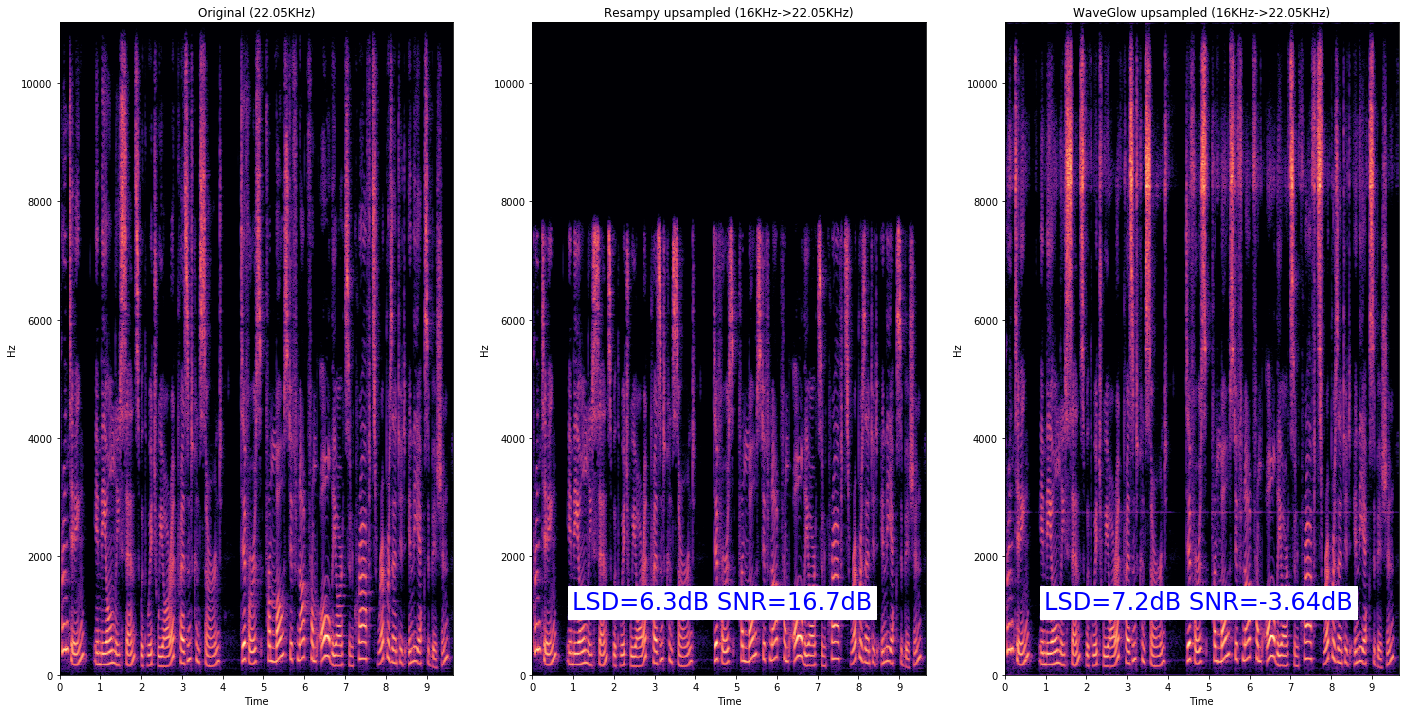

In [62]:
true_specgram, ds_specgram, synth_specgram, reco_lsd, ds_lsd, reco_snr, ds_snr, sr_orig, sr_synth = get_lsd_snr(orig_path, synth_path)

# Make the plot
plt.figure(figsize=(24,12))
plot_specgram(true_specgram, 'Original (22.05KHz)', sr_orig, 131)
ax = plot_specgram(ds_specgram, 'Resampy upsampled (16KHz->22.05KHz)', sr_orig, 132)
ax.text(0.1, 0.1, r'LSD={:.3}dB SNR={:.3}dB'.format(ds_lsd, ds_snr),
        color='blue', fontsize=24, transform=ax.transAxes,
        backgroundcolor='white');
ax = plot_specgram(synth_specgram, 'WaveGlow upsampled (16KHz->22.05KHz)', sr_synth, 133)
ax.text(0.1, 0.1, r'LSD={:.3}dB SNR={:.3}dB'.format(reco_lsd, reco_snr),
        color='blue', fontsize=24, transform=ax.transAxes,
        backgroundcolor='white');
plt.savefig('waveglow_example.png', dpi=200)

# Directory level stats

In [63]:
originals = []
    
with open('test_files.txt') as f:
    for fname in f:
        originals.append(fname.strip())
    
wav_dir = "test/synth"
synth = []
paired = []
for wav in glob.glob(wav_dir + '/' + "*.wav"):
    for fname in originals:
        if wav.endswith(fname.split('/')[-1]):
            paired.append((fname, wav))
            break
    synth.append(wav)

In [64]:
agg = {}
for orig_path, synth_path in paired:
    true_specgram, ds_specgram, synth_specgram, reco_lsd, ds_lsd, reco_snr, ds_snr, sr_orig, sr_synth = get_lsd_snr(orig_path, synth_path)
    agg[orig_path.split('/')[-1]]= {'WaveGlow LSD': reco_lsd, 'Kaiser LSD': ds_lsd, 'WaveGlow SNR': reco_snr, 'Kaiser SNR': ds_snr}
df = pd.DataFrame(agg).T

In [65]:
df

,WaveGlow LSD,Kaiser LSD,WaveGlow SNR,Kaiser SNR
LJ001-0006.wav,7.121436,6.067158,-3.589201,15.269046
LJ001-0004.wav,8.219603,7.475301,-3.625958,14.341605
LJ001-0001.wav,7.200636,6.303971,-3.636254,16.739411
LJ001-0007.wav,7.601234,5.988520,-3.729928,21.080027
LJ001-0010.wav,8.305168,7.594619,-3.457351,11.446275
LJ001-0002.wav,6.936355,5.727254,-1.736453,28.692958
LJ001-0003.wav,7.068816,5.411350,-3.148376,14.001662
LJ001-0005.wav,6.795152,6.461061,-3.187745,17.515537
LJ001-0009.wav,8.797977,5.634901,-2.572204,15.234863
LJ001-0008.wav,7.688354,7.708004,-4.345017,16.153333


In [55]:
print(m.to_latex())

\begin{tabular}{lr}
\toprule
{} &          0 \\
\midrule
WaveGlow LSD &   7.573473 \\
Kaiser LSD   &   6.437214 \\
WaveGlow SNR &  -3.302849 \\
Kaiser SNR   &  17.047472 \\
\bottomrule
\end{tabular}

